# US Beveridge Curve Data 

Construct monthly unemploment rate and vacancy rate series for the US from April 1929 through the most recently available date. The methodology is based on the approach described in Petrosky-Nadeau and Zhang (2013): https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2241695

1. This Notebook is compatible with Python 2 and 3.

2. **To use this notebook to download the entire dataset, you need the X-13ARIMA-SEATS binary**. If you don't have the binary, set variable `x_13` to `False`. Data that require seasonal adjustment will be loaded from the `txt` directory of the parent directory to this program.

Binaries for Windows and Linux/Unix are available from https://www.census.gov/srd/www/x13as/. To compile X-13 for Mac OS X, see the instructions here: https://github.com/christophsax/seasonal/wiki/Compiling-X-13ARIMA-SEATS-from-Source-for-OS-X.

In [1]:
import statsmodels as sm
import fredpy as fp
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
import pandas as pd
import os,urllib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# You must change XPATH if you are running this script from anywhere other than the directory containing x13as.
XPATH = os.getcwd()

# Load fredpy api key
fp.api_key = fp.load_api_key('fred_api_key.txt')

# Whether x13 binary is available
x_13 = False

## Unemployment Rate

Construct an unemployment series from April 1929 through the most recent date available by concatenating four U.S. unemployment rate series; all of which are available from FRED (https://fred.stlouisfed.org/). Specifically:

1. Seasonally adjusted unemployment rate for the United States from April 1929 through February 1940. FRED series ID: M0892AUSM156SNBR. NBER Indicator: m08292a. 
2. Seasonally adjusted unemployment rate for the United States from March 1940 through December 1946. FRED series ID: M0892BUSM156SNBR. NBER Indicator: m08292b. 
3. Seasonally adjusted unemployment rate for the United States from January 1947 through  December 1947. FRED series ID: M0892CUSM156NNBR. NBER Indicator: m08292c.  Note: The source data are not seasonally adjusted and contain observations through December 1966. Seasonally adjust the entire series through December 1966 using the U.S. Census Bureau's X-13-ARIMA seasonal adjustment program. Then discard values after December 1947. *Only downloaded if `x_13 == True.`*
4. Seasonally adjusted unemployment rate for the United States from January 1948 through the most recent date available. FRED series ID: UNRATE.

In [2]:
# Historical US unemployment rate from the NBER Macrohistory Database: 1929-04-01 to 1940-02-01;
# Seasonally adjusted

# Download from FRED and save as a Pandas series
unemp_1 = fp.series('M0892AUSM156SNBR')
unemp_1 = unemp_1.window(['04-01-1929','02-01-1940']).data

In [3]:
# Historical US unemployment rate from the NBER Macrohistory Database: 1940-03-01 to 1946-12-01;
# Seasonally adjusted

# Download from FRED and save as a Pandas series
unemp_2 = fp.series('M0892BUSM156SNBR')
unemp_2 = unemp_2.window(['03-01-1940','12-01-1946']).data

In [4]:
# Historical US unemployment rate from the NBER Macrohistory Database: 1947-01-01 to 1966-12-01;
# Raw series is *not* seasonally adjusted

if x_13:
    
    # Download from FRED
    unemp_3 = fp.series('M0892CUSM156NNBR')
    unemp_3 = unemp_3.window(['01-01-1947','12-01-1966']).data

    # Run x13_arima_analysis to obtain SA unemployment data.
    x13results = sm.tsa.x13.x13_arima_analysis(endog = unemp_3,x12path=XPATH, outlier=False,print_stdout=True)

    unemp_3 = pd.Series(x13results.seasadj.values,index=unemp_3.index)
    unemp_3 = unemp_3[(unemp_3.index>=pd.to_datetime('01-01-1947')) & (unemp_3.index<=pd.to_datetime('12-01-1947'))]

    # Export the series to txt
    unemp_3.to_csv('../txt/unemployment_1947.txt',sep='\t')
    
else:
    
    # Import data
    unemp_3 = pd.read_csv('../txt/unemployment_1947.txt',sep='\t',index_col=0,parse_dates=True)['0']

In [5]:
# US civilian unemployment rate from the BLS: 1948-01-01 to most recent;
# Seasonally  adjusted
unemp_4 = fp.series('UNRATE')
unemp_4 = unemp_4.window(['01-01-1948','01-01-2200']).data

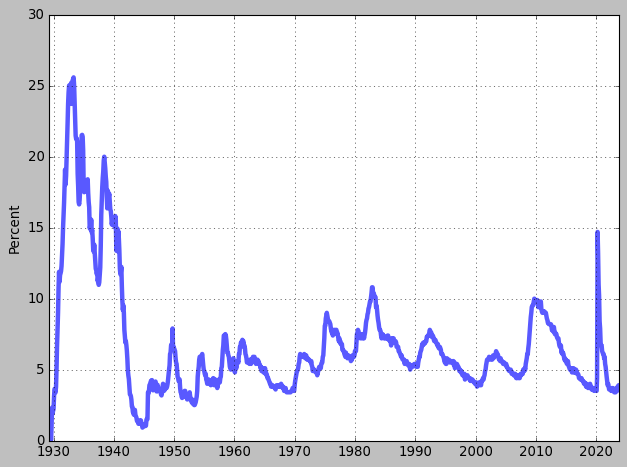

In [6]:
# Concatenate the first three series
unemployment_rate_series = pd.concat([unemp_1,unemp_2]).sort_index()
unemployment_rate_series = pd.concat([unemployment_rate_series,unemp_3]).sort_index()
unemployment_rate_series = pd.concat([unemployment_rate_series,unemp_4]).sort_index()

# plot the series and save the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(unemployment_rate_series,'-',lw=4,alpha = 0.65)
ax.set_ylabel('Percent')
ax.grid()

fig.tight_layout()
plt.savefig('../png/fig_data_unrate.png',bbox_inches='tight',dpi=120)


## Vacancies (Job openings)

Construct a series of vacancies for the United States going back to April 1929 by scaling and concatenating three series:
1. Help-wanted advertising in newspapers index for United States from April 1929 to January 1960. FRED series ID: M0882AUSM349NNBR. NBER Indicator: m08082a. Note: The source data are not seasonally adjusted and contain observations through August 1960. Seasonally adjust the entire series through August 1960 using the United States Census Bureau's X-13-ARIMA seasonal adjustment program. Then discard values after January 1960. *Only downloaded if `x_13 == True.`*
2. Composite help-wanted index from January 1960 through January 2001 constructed using the method described in and Barnichon (2010). The data are from Barnichon's website https://sites.google.com/site/regisbarnichon/data. Scale this series so that its value in January 1960 equals the value of the NBER's help-wanted index for the same date.
3. Job openings, total nonfarm for the United States from January 2001 to the most recent date available. FRED series ID: JTSJOL. Scale this series so that its value in January 2001 equals the value of the scaled help-wanted index from Barnichon for the same date.

In [7]:
if x_13:
    
    # Met life help-wanted index: 1919-01-01 to 1960-08-01;
    
    # Not seasonally adjusted
    vac_1 = fp.series('M0882AUSM349NNBR').data

    # temp_series = pd.Series(vac_1.data,index=pd.to_datetime(vac_1.dates))

    # Run x13_arima_analysis to obtain SA vacancy rate data.
    x13results = sm.tsa.x13.x13_arima_analysis(endog = vac_1,x12path=XPATH, outlier=False,print_stdout=True)

    vac_1 = pd.Series(x13results.seasadj.values,index=vac_1.index)
    vac_1 = vac_1[(vac_1.index>=pd.to_datetime('04-01-1929')) ]

    # Export the series to txt
    vac_1.to_csv('../txt/vacancies_1929-1960.txt',sep='\t')
    
else:
    
    vac_1 = pd.read_csv('../txt/vacancies_1929-1960.txt',sep='\t',index_col=0,parse_dates=True)['0']

In [8]:
# Composite help-wanted index from Regis Barnichon's site: https://sites.google.com/site/regisbarnichon;
# Seasonally adjusted

# Import data from Regis Barnichon's site
dls = 'https://sites.google.com/site/regisbarnichon/cv/HWI_index.txt?attredirects=0'
try:
    urllib.urlretrieve(dls, '../txt/HWI_index.txt')
except:
    try:
        urllib.request.urlretrieve(dls, '../txt/HWI_index.txt')
    except:
        print('HWI_index.txt is no longer available at given URL')

vac_2 = pd.read_csv('../txt/HWI_index.txt',delimiter='\t',skiprows=6)
vac_2.columns = ['Date','composite HWI']

# Manage dates
dates = []
for d in vac_2['Date']:
    dates.append(d[-2:]+'-01-'+d[0:4])

vac_2 = pd.Series(vac_2['composite HWI'].values,index = pd.to_datetime(dates))

# Compute a scaling factor to ensure that the January 1, 1960 values of the first vacancy series match 
# the second.
scaling = vac_1.loc['01-01-1960']/vac_2.loc['1960-01-01']
vac_2 = scaling* vac_2

HWI_index.txt is no longer available at given URL


In [9]:
# Job Openings and Labor Turnover Survey (JOLTS) : December 1, 2000 to present
# Seasonally adjusted

vac_3 = fp.series('JTSJOL').data

# Compute a scaling factor to ensure that the December 1, 2000 values of the first vacancy series match 
# the second.
scaling = vac_2.loc['12-01-2000']/vac_3.loc['12-01-2000']
vac_3 = scaling* vac_3

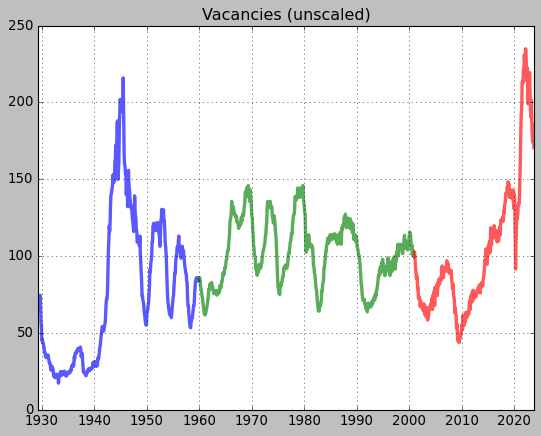

In [10]:
# Truncate each series
vac_1 = vac_1.loc[:'12-01-1959']
vac_2 = vac_2.loc['01-01-1960':'12-01-2000']
vac_3 = vac_3.loc['01-01-2001':]

# Plot the three truncated and scaled series to verify that they line up
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(vac_1,'-',lw=3,alpha = 0.65)
ax.plot(vac_2,'-',lw=3,alpha = 0.65)
ax.plot(vac_3,'-',lw=3,alpha = 0.65)
ax.set_title('Vacancies (unscaled)')
ax.grid()

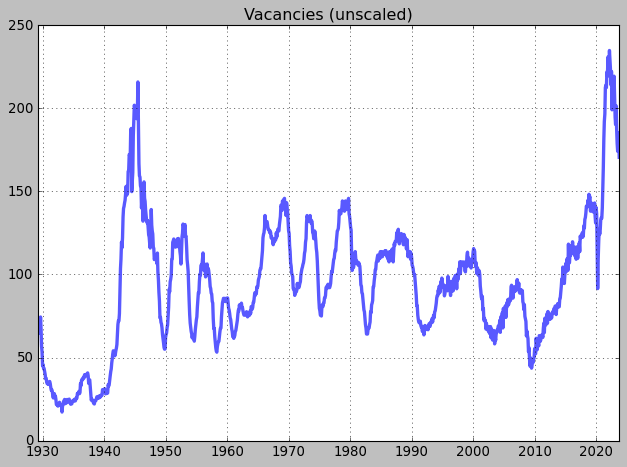

In [11]:
# Create the vacancy series
vacancy_series_unscaled = pd.concat([vac_1,vac_2]).sort_index()
vacancy_series_unscaled = pd.concat([vacancy_series_unscaled,vac_3]).sort_index()

# plot the series and save the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot_date(vacancy_series_unscaled.index,vacancy_series_unscaled.values,'-',lw=3,alpha = 0.65)
ax.set_title('Vacancies (unscaled)')
ax.grid()

fig.tight_layout()
plt.savefig('../png/fig_data_vacancies.png',bbox_inches='tight',dpi=120)

## Labor force data

Next, construct monthly labor force data for the United States from April 1929 by concatenating two series:
1. Civilian labor force for the United States from January 1948 to the most recent date available. FRED series ID: CLF16OV.
2. Historical national population estimates from  Population Estimates Program, Population Division, U.S. Census Bureau. The source data are annual from July 1, 1900 to July 1, 1999 and not seasonally adjusted. Extend the data to monthly frequency by linear interpolation and discard observations before April 1929 and after January 1948. Then scale this series so that its value in January 1948 equals the value of the civilian labor force series for the same date.

In [12]:
# Civilian labor force over 16 years of age in thousands of persons: January 1948 to present;
# Seasonally adjusted
lf_1 = fp.series('CLF16OV')
lf_1 = lf_1.window(['01-01-1800','06-01-2216']).data

In [13]:
# Historical National Population Estimates:  July 1, 1900 to July 1, 1999
# Source: Population Estimates Program, Population Division, U.S. Census Bureau
# Annual, Not seasonally adjusted

# Retrieve data from Census
dls = 'http://www.census.gov/popest/data/national/totals/pre-1980/tables/popclockest.txt'
dls = 'https://www.census.gov/population/estimates/nation/popclockest.txt'
dls = 'https://www2.census.gov/programs-surveys/popest/tables/1900-1980/national/totals/popclockest.txt'

try:
    urllib.urlretrieve(dls, '../txt/popclockest.txt')
except:
    try:
        urllib.request.urlretrieve(dls, '../txt/popclockest.txt')
    except:
        print('popclockest.txt is no longer available at given URL')

# Import data and edit file
with open('../txt/popclockest.txt','r') as newfile:
    lines = newfile.readlines()
    
# Remove leading and trailing whitespace and overwrite spaces in with tabs in lines
newlines = []
for i,line in enumerate(lines):
    
    newline = line.rstrip().lstrip()
    newline = newline.replace('              ','\t')
    newline = newline.replace('          ','\t')
    newline = newline.replace('      ','\t')
    newline = newline+'\n'
    newlines.append(newline)

# Collect the population and date information
pop = []
dates=[]
for i,line in enumerate(newlines[9:]):
    
    if len(line.split('\t'))==4:
        line_split = line.split('\t')
        dates.append(line_split[0])
        pop.append(float(line_split[1].replace(',','')))

# Form the series
lf_2 = pd.Series(pop,index = pd.to_datetime(dates))

# Resample data as monthly and interpolate
lf_2 = lf_2.sort_index()
lf_2 = lf_2.resample('M').mean().interpolate()

# Set dates to begining of month instead of middle
lf_2.index = lf_2.index + pd.offsets.MonthBegin(0)

# Compute a scaling factor to ensure that the Jaunary 1, 1948 values of the first LF series match 
# the second.
scaling = lf_1.iloc[0]/lf_2[lf_2.index==pd.to_datetime('1948-01-01')].values[0]
lf_2 = scaling*lf_2[(lf_2.index>=pd.to_datetime('1929-04-01')) & (lf_2.index<pd.to_datetime('1948-01-01'))]

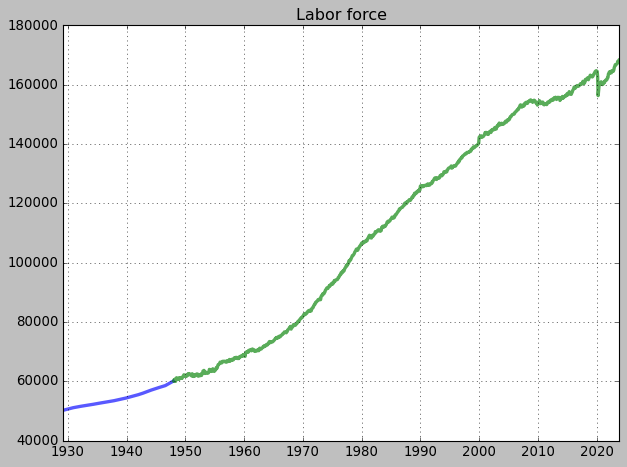

In [14]:
# Plot the two truncated and scaled series to verify that they line up
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(lf_2,'-',lw=3,alpha = 0.65)
ax.plot(lf_1,'-',lw=3,alpha = 0.65)
ax.set_title('Labor force')
ax.grid()

fig.tight_layout()

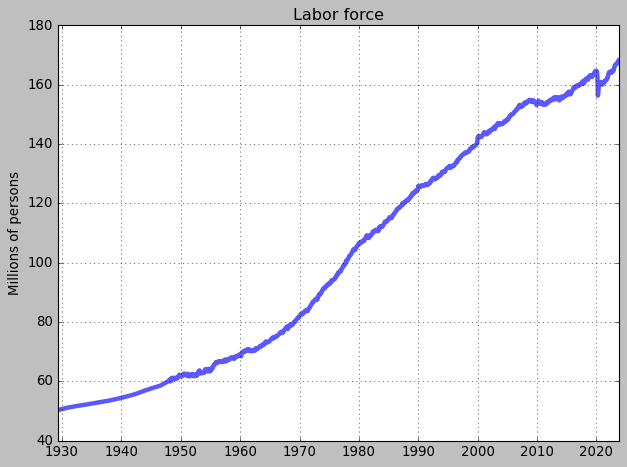

In [15]:
# form the labor force series
labor_force_series = pd.concat([lf_1,lf_2]).sort_index()

# plot the series and save the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(labor_force_series/1000,'-',lw=4,alpha = 0.65)
ax.set_title('Labor force')
ax.set_ylabel('Millions of persons')
ax.grid()

fig.tight_layout()
plt.savefig('../png/fig_data_labor_force.png',bbox_inches='tight',dpi=120)

## Vacancy rate

Now with a vacancy series and a labor force series, compute the monthly vacancy rate for the Unite States by dividing the vacancy rate series by the labor force series. Following Petrosky-Nadeau and Zhang (2013), scale the result so that the average vacancy rate for 1965 is 2.05\% in order to match the vacancy rate estimate for 1965 obtained by Zagorsky (1998).

In [16]:
# Construct the vacancy_rate series
vacancy_rate_series = vacancy_series_unscaled / labor_force_series

# Compute a scaling factor to ensure that the average vacancy rate for 1965 is 0.0205
scaling = vacancy_rate_series[(vacancy_rate_series.index>=pd.to_datetime('1965-01-01')) & (vacancy_rate_series.index<=pd.to_datetime('1965-12-01'))].mean()/0.0205

vacancy_rate_series = 100*vacancy_rate_series/scaling

vacancy_series = vacancy_rate_series*labor_force_series/100
unemployment_series = unemployment_rate_series*labor_force_series/100
market_tightness_series = vacancy_series/unemployment_series

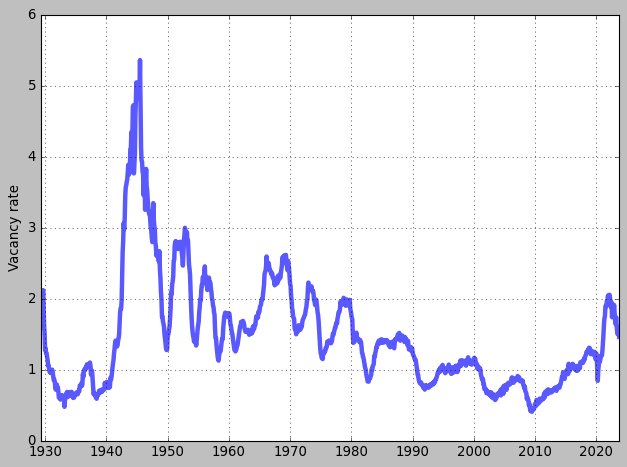

In [17]:
# plot the series and save the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(vacancy_rate_series,'-',lw=4,alpha = 0.65)
ax.set_ylabel('Vacancy rate')
ax.grid()

fig.tight_layout()
plt.savefig('../png/fig_data_vacancy_rate.png',bbox_inches='tight',dpi=120)

## Organize data

In the rest of the program, organize the data into DataFrames, construct plots that used in the paper, and export datasets that can be used to replicate the figures and to investigate carefully the data more carefully.

In [18]:
# Organize data into DataFrames
df_rates = pd.concat([unemployment_rate_series,vacancy_rate_series,market_tightness_series], join='outer', axis = 1).dropna()
df_rates.columns = ['Unemployment rate','Vacancy rate','Market tightness']

df_levels= pd.concat([unemployment_series,labor_force_series,vacancy_series], join='outer', axis = 1).dropna()
df_levels.columns = ['Unemployment [Thousands of persons]','Labor force [Thousands of persons]','Vacancies [Thousands of vacancies]']

df_all = pd.concat([df_rates,df_levels], join='outer', axis = 1).dropna()

# Subframes for pre December 2007 and after
df_pre_gr = df_all[(df_all.index< '12-01-2007')]
df_post_gr = df_all[(df_all.index>= '12-01-2007')]

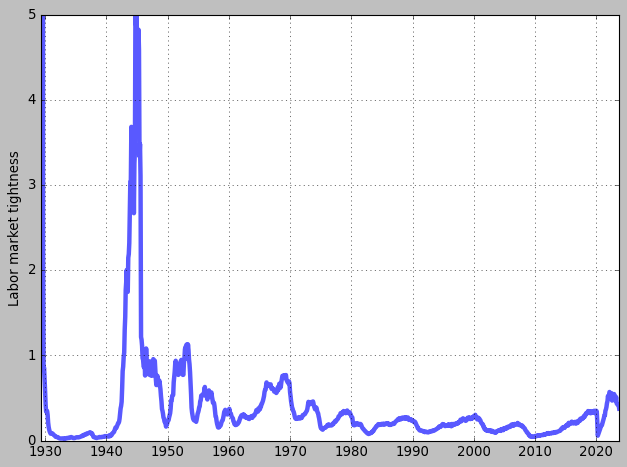

In [19]:
# plot the labor market tightness series and save the figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot_date(df_all.index,df_all['Market tightness'].values,'-',lw=4,alpha = 0.65)
# plt.scatter(df_all['Unemployment rate'].values,df_all['Market tightness'].values,s=45,c= 'blue',alpha = 0.25)
ax.set_ylabel('Labor market tightness')
ax.set_ylim([0,5])
ax.grid()

fig.tight_layout()
plt.savefig('../png/fig_data_market_tightness.png',bbox_inches='tight',dpi=120)

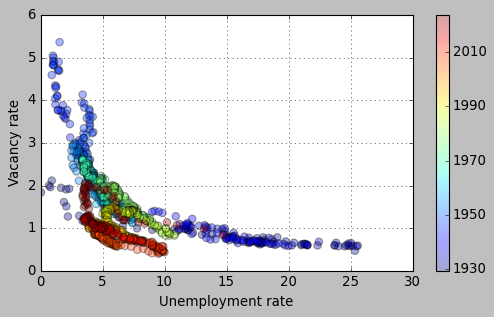

In [20]:
# Plot the Beveridge curve for the US: vacancy rate v unemployment rate

fig = plt.figure(figsize=(7.5,4))
ax = fig.add_subplot(1,1,1)
c = np.arange(len(df_all.index))
plt.scatter(df_all['Unemployment rate'].values,df_all['Vacancy rate'].values,s=45,c= c,alpha = 0.35)
ax.set_xlim([0,30])
ax.set_ylim([0,6])
# ax.set_title('Beveridge curve')
ax.set_xlabel('Unemployment rate')
ax.set_ylabel('Vacancy rate')
ax.grid()

##############################################################################################
# Old code to set colorbar labels
# cbar = plt.colorbar(ax = ax)
# cbar.get_ticks()
# cbar.set_ticks([int(i) for i in cbar.get_ticks()[:-1]])
# cbar.set_ticklabels([df_all.index[int(i)].strftime('%b %Y') for i in cbar.get_ticks()[:]])
##############################################################################################

cbar = plt.colorbar(ax = ax)
num_ticks = int((df_all.index[-1].year-1930)/20)+1
tick_dates = [str(1930 + i*20)+'-01-01' for i in range(num_ticks)]
ticks = df_all.reset_index().index[df_all.index.isin(tick_dates)].tolist()
cbar.set_ticks(ticks)
cbar.set_ticklabels([df_all.index[int(i)].strftime('%Y') for i in ticks])

plt.savefig('../png/fig_beveridge_curve.png',bbox_inches='tight',dpi=120)

In [21]:
cbar.get_ticks()

array([  9, 249, 489, 729, 969])

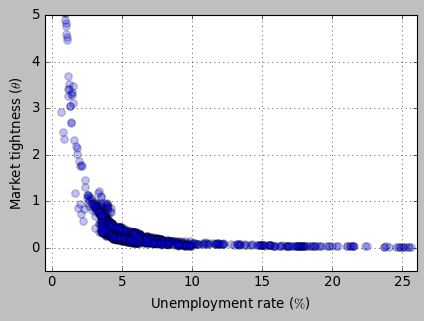

In [22]:
# Plot the modified Beveridge curve for the US: market tightness v unemployment rate

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)
c = np.arange(len(df_all.index))
plt.scatter(df_all['Unemployment rate'].values,df_all['Market tightness'].values,s=45,c= 'blue',alpha = 0.25)
ax.set_xlim([-0.5,26])
ax.set_ylim([-0.5,5])
# ax.set_title('Modified Beveridge curve')
ax.set_xlabel('Unemployment rate ($\%$)')
ax.set_ylabel('Market tightness ($\\theta$)')
ax.grid()

plt.savefig('../png/fig_modified_beveridge_curve.png',bbox_inches='tight',dpi=120)

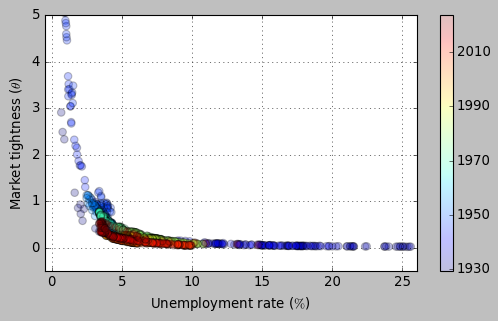

In [23]:
# Plot the modified Beveridge curve for the US: market tightness v unemployment rate

fig = plt.figure(figsize=(7.5,4))
ax = fig.add_subplot(1,1,1)
c = np.arange(len(df_all.index))
plt.scatter(df_all['Unemployment rate'].values,df_all['Market tightness'].values,s=45,c=c,alpha = 0.25)
ax.set_xlim([-0.5,26])
ax.set_ylim([-0.5,5])
# ax.set_title('Modified Beveridge curve')
ax.set_xlabel('Unemployment rate ($\%$)')
ax.set_ylabel('Market tightness ($\\theta$)')
ax.grid()

cbar = plt.colorbar(ax = ax)
num_ticks = int((df_all.index[-1].year-1930)/20)+1
tick_dates = [str(1930 + i*20)+'-01-01' for i in range(num_ticks)]
ticks = df_all.reset_index().index[df_all.index.isin(tick_dates)].tolist()
cbar.set_ticks(ticks)
cbar.set_ticklabels([df_all.index[int(i)].strftime('%Y') for i in ticks])


plt.savefig('../png/fig_modified_beveridge_curve_color.png',bbox_inches='tight',dpi=120)

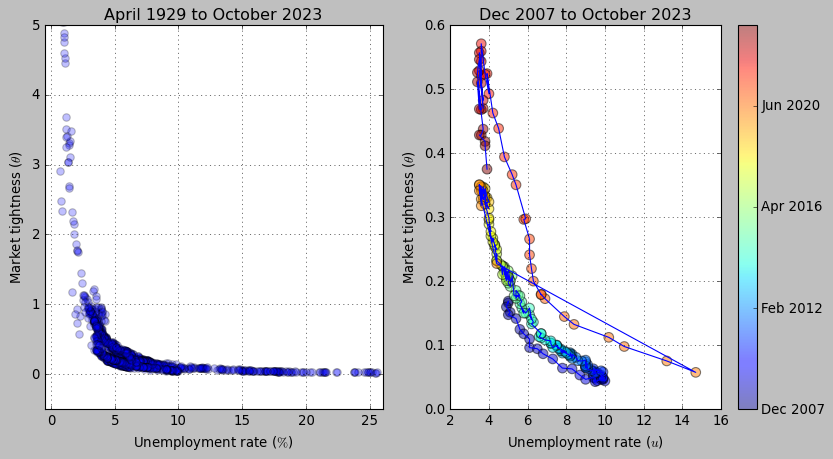

In [24]:
# Construct figure for paper

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
c = np.arange(len(df_all.index))
plt.scatter(df_all['Unemployment rate'].values,df_all['Market tightness'].values,s=45,c= 'blue',alpha = 0.25)
ax.set_xlim([-0.5,26])
ax.set_ylim([-0.5,5])
ax.set_title(df_all.index[0].strftime('%B %Y')+' to '+df_all.index[-1].strftime('%B %Y'))
ax.set_xlabel('Unemployment rate ($\%$)')
ax.set_ylabel('Market tightness ($\\theta$)')
ax.grid()

ax = fig.add_subplot(1,2,2)

c = np.arange(len(df_post_gr.index))

plt.scatter(df_post_gr['Unemployment rate'].values,df_post_gr['Market tightness'].values,s=75,alpha = 0.5,c=c)

cbar = plt.colorbar(ax = ax)
cbar.set_ticks([int(i) for i in cbar.get_ticks()[:-1]])
cbar.set_ticklabels([df_post_gr.index[int(i)].strftime('%b %Y') for i in cbar.get_ticks()])

plt.plot(df_post_gr['Unemployment rate'].values,df_post_gr['Market tightness'].values,'-')

ax.set_title(df_post_gr.index[0].strftime('%b %Y')+' to '+df_post_gr.index[-1].strftime('%B %Y'))
ax.set_xlabel('Unemployment rate ($u$)')
ax.set_ylabel('Market tightness ($\\theta$)')
ax.grid()

plt.savefig('../png/fig_modified_beveridge_curve_both.png',bbox_inches='tight',dpi=120)

In [25]:
# Export data to csv
df_levels.to_csv('../csv/beveridge_curve_data.csv',index_label='Date',float_format='%11.2f')